---
## Anzahl der Trainingsdaten Test
by Tobia Ippolito
### Contents:
- [Beschreibung](#Beschreibung)
- [Imports](#Imports)
- [Experiment](#Experiment)
- [Experiment 2](#Experiment_2_(andere_personenkonstellation))
- [Ergebnis](#Ergebnis)

<br>
<br>

---

### Beschreibung
Es soll getestet werden, mit wie vielen Trainingsdaten der Algorithmus noch zurechtkommt. Um das gut mitteln zu können, wird von 95-5% in 5-er Schritten der Trainingsdatensatz verringert. Außerdem wird jeder Schritt mehrmals ausgeführt und der Durchschnitt hiervon genommen, um das Experiment nicht mit schlechte Dateneintragskonstellationen manipulieren zu lassen.<br>
<br>

---
### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../src')

In [2]:
import anoog
from anoog.model import predict_proba
from anoog.model import train_random_forest

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [4]:
import random

---
### Experiment

Load Data

In [6]:
data = anoog.io.load_data("../../data/2021-11-09",
                                ['tippolit', 'vkorzev'],
                                extraction=anoog.io.extraction_mode.MANUEL,
                                selection=anoog.io.selection_mode.NONE,
                                train_test_split=False)
data.tail()

,audio_min,audio_max,audio_mean,audio_median,audio_std,current_min,current_max,current_mean,current_median,current_std,...,voltage_mean,voltage_median,voltage_std,Time,Resistance,Power,Work,mAh,Wh,y
45,-3.813901,3.485494,-0.005958,-0.000307,0.923199,-0.841899,30.302135,1.953009,1.898246,2.931288,...,19.236397,19.249631,0.376643,5.76,0.101527,37.568856,216.396609,32.550150,626.147595,1
46,-3.805070,3.467371,-0.002143,-0.000328,0.879257,-0.847336,29.887917,1.977015,2.087429,2.853247,...,19.227930,19.237225,0.363789,5.15,0.102820,38.013911,195.771642,32.950254,633.565184,1
47,-2.896698,2.937443,-0.007464,-0.000168,0.639745,-0.939453,6.131235,1.610943,1.825491,1.252940,...,19.248177,19.219212,0.172090,6.51,0.083693,31.007708,201.860179,26.849043,516.795133,1
48,-3.804612,3.442479,-0.004583,-0.000233,0.841846,-0.939453,32.809911,2.206411,2.178879,3.070032,...,19.171210,19.177871,0.387968,5.14,0.115090,42.299573,217.419805,36.773520,704.992883,1
49,-2.493667,3.257855,0.005086,-0.003672,0.731803,-0.939453,32.370458,2.355542,2.410300,2.951833,...,19.132585,19.114923,0.375963,5.22,0.123117,45.067612,235.252934,39.259037,751.126866,1


In [7]:
X, y = anoog.io.X_y_split(data)

Helper Functions (for plotting)

In [67]:
def plot_acc(result):
    acc = list(map(lambda x:x[0], result))
    train_data_size = list(map(lambda x:x[1], result))
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 8))

    plt.style.use('seaborn-whitegrid')

    ax[0].stem(train_data_size, acc)
    ax[0].grid()
    ax[0].set_title("Accuracy bei Veränderung der Größe der Trainingsdaten (Stemplot)")
    ax[0].set_xlabel("Traindata-Size")
    ax[0].set_ylabel("Accuracy")
    ax[0].set_ylim(ymin=0, ymax=100)

    ax[1].plot(train_data_size, acc) 
    ax[1].grid()
    ax[1].set_title("Accuracy bei Veränderung der Größe der Trainingsdaten (Lineplot)")
    ax[1].set_xlabel("Traindata-Size")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_ylim(ymin=0, ymax=100)

Experiment Function

In [28]:
def split_experiment(model_method=train_random_forest, amount_of_tries_per_step=3, start=90, stop=0, stepsize=5):
    result = []    # [(acc, traindata_amount)]
    for test_size_perc in range(100-start, 100-stop, stepsize):
        test_size = test_size_perc/100
        cache = []
        for t in range(amount_of_tries_per_step):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y) 

            # train model
            model = model_method(X_train, y_train, auto_params=False, normalize=True)

            # predict predict_data, X_train, normalize=False)
            #result = anoog.predict_proba(model, X_test, X_train, normalize=True)
            cache += [anoog.model.evaluate_model(model, X_test, y_test, X_train, normalize=True)[0]]
        result += [(np.mean(cache), len(X_train))]

    result_str = f"Info:\n  Train-Data-Amount in percentage: {list(range(start, stop, -stepsize))}"
    result_str += f"\n  Mean of {amount_of_tries_per_step} predictions per step.\n  Model:{model_method.__name__}"
    #result_str += f"\n\nAccuracy:\n  Mean: {round(np.mean(result)[0], 2)}%, Median: {round(np.median(result)[0],2)}%"
    #result_str += f"\n  Min: {round(np.min(result)[0],2)}%, Max: {round(np.max(result),2)}%\n  Variance: {round(np.std(result)[0],2)}"
    print(result_str)
    plot_acc(result)

Testing/Execute Experiment

Info:
  Train-Data-Amount in percentage: [90, 88, 86, 84, 82, 80, 78, 76, 74, 72, 70, 68, 66, 64, 62, 60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4]
  Mean of 10 predictions per step.
  Model:train_svc


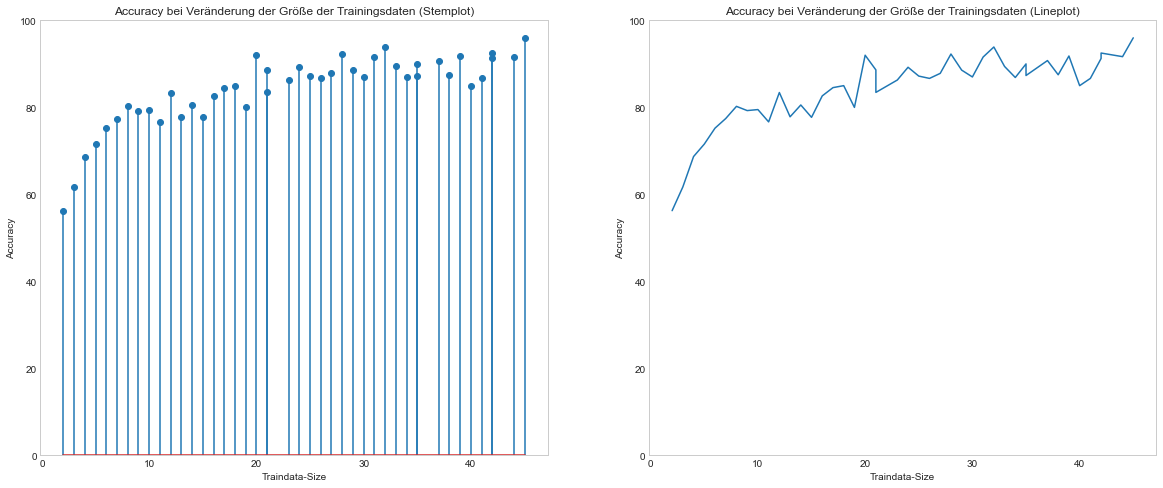

In [68]:
split_experiment(model_method=anoog.model.train_svc, amount_of_tries_per_step=10, start=90, stop=3, stepsize=2)

Info:
  Train-Data-Amount in percentage: [20, 18, 16, 14, 12, 10, 8, 6, 4]
  Mean of 50 predictions per step.
  Model:train_svc


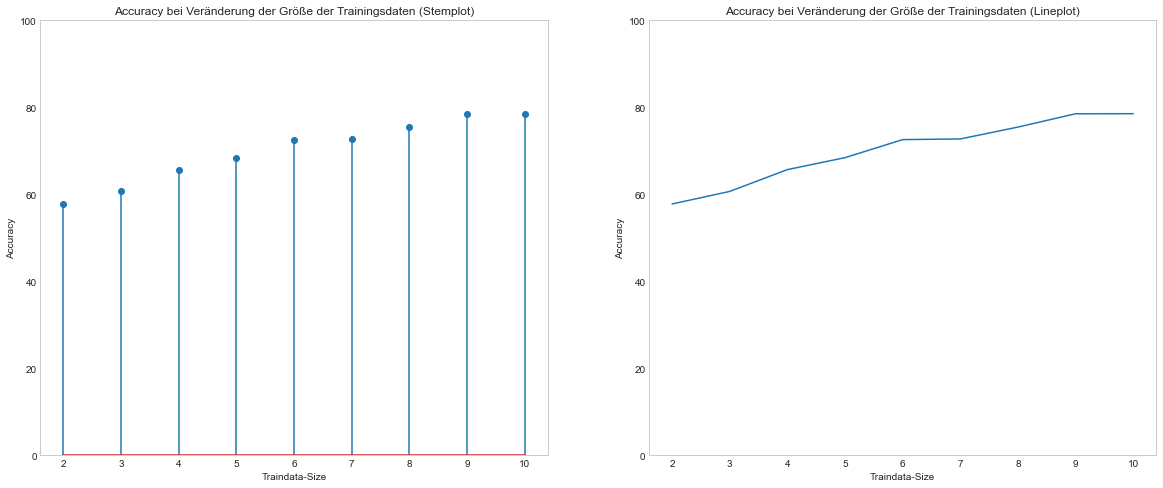

In [73]:
split_experiment(model_method=anoog.model.train_svc, amount_of_tries_per_step=50, start=20, stop=3, stepsize=2)

---
### Experiment 2 (andere personenkonstellation)

Load Data

In [75]:
data = anoog.io.load_data("../../data/2021-11-09",
                                ['tippolit', 'skadkade'],
                                extraction=anoog.io.extraction_mode.MANUEL,
                                selection=anoog.io.selection_mode.NONE,
                                train_test_split=False)

In [77]:
X, y = anoog.io.X_y_split(data)

Info:
  Train-Data-Amount in percentage: [90, 88, 86, 84, 82, 80, 78, 76, 74, 72, 70, 68, 66, 64, 62, 60, 58, 56, 54, 52, 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14, 12, 10, 8, 6, 4]
  Mean of 10 predictions per step.
  Model:train_svc


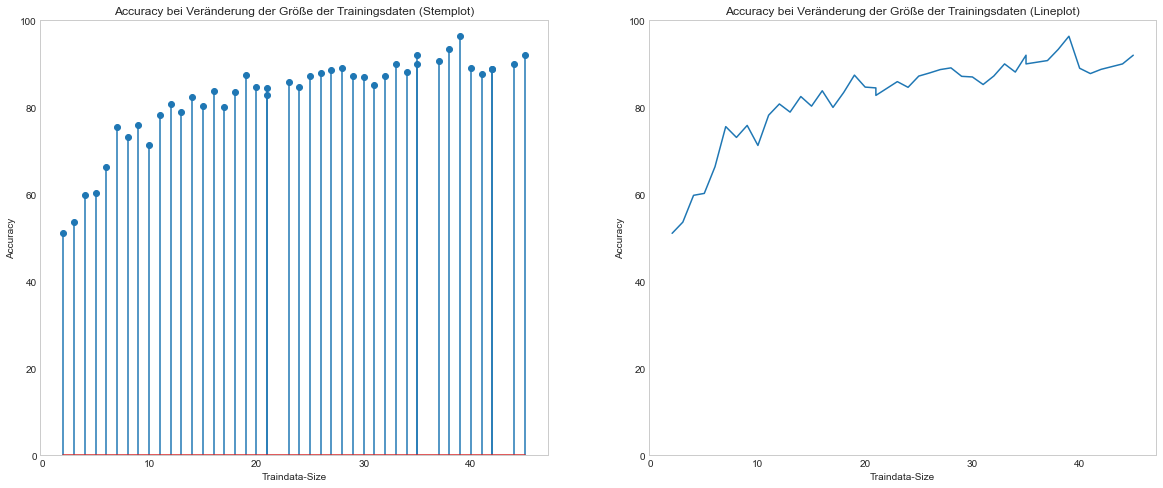

In [78]:
split_experiment(model_method=anoog.model.train_svc, amount_of_tries_per_step=10, start=90, stop=3, stepsize=2)

Info:
  Train-Data-Amount in percentage: [20, 18, 16, 14, 12, 10, 8, 6, 4]
  Mean of 50 predictions per step.
  Model:train_svc


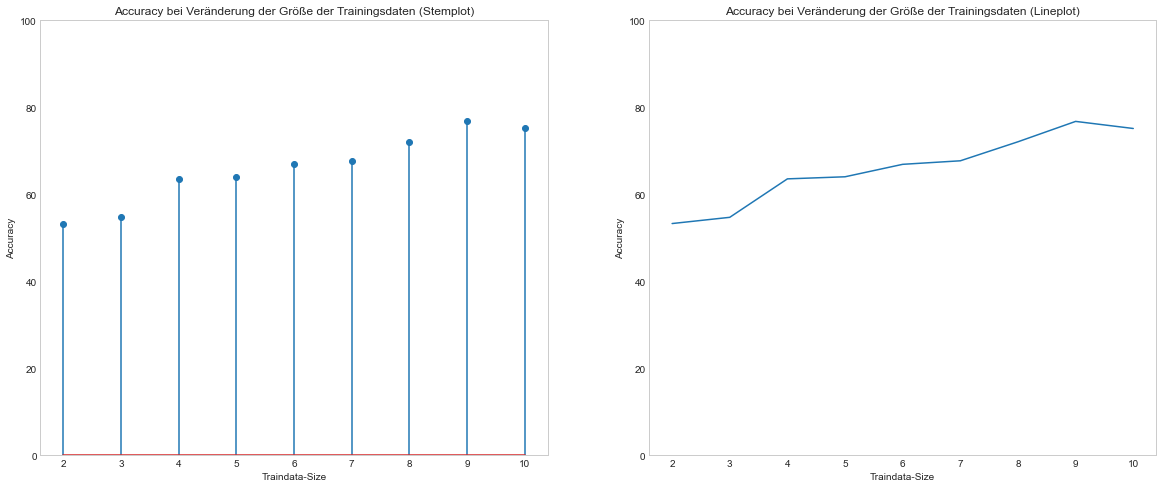

In [80]:
split_experiment(model_method=anoog.model.train_svc, amount_of_tries_per_step=50, start=20, stop=3, stepsize=2)

---
### Ergebnis

Die Accuracy steigt bei wenigen Datensätzen (2-10 Dateneinträge) rasant an (Personenunabhängig). Dann erhöht sich die Accuracy nur noch langsam.<br>
<br>
Ab welcher Trainingsdatenanzahl die Accuracy nur noch langsam steigt ist etwas schwer einzuschätzen und scheint zu variieren (ca 6-10). Des weiteren scheint es auch Schwankungen zu geben, bei denen die Accuracy wieder etwas geringer wird, obwohl mehr Trainingsdaten vorhanden sind. 

Hinweis: Bedenke, die Werte oben wurden über mehrere Läufe gemittelt und die Daten werden jedes mal geshuffelt -> ungünstige Datenkonstellationen sollten diese Ergebnisse also nicht/nur geringfügig manipuliert haben.

---